# Spam Classification using Encoder LLMs with Linear Probing

**Dataset:** Enron Spam Dataset <br>
**Dataset URL:** https://huggingface.co/datasets/SetFit/enron_spam <br>
**Expected Performance (Best Model):** {Accuracy: >85%, F1: >85%, Precision: >85%, Recall: >82%} <br>

1. Loading the Enron Spam dataset & train/val/test splits & tokenize the text using a pre-trained LLM’s tokenizer.

This code preprocesses the Enron Spam dataset using a tokenizer based on a pretrained model. It tokenizes the text depending on truncation and padding to the max length. The original training set is splited into training and validation sets.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

dataset = load_dataset("SetFit/enron_spam")

def tokenize_function(sentence, tokenizer, max_length = 128):
    return tokenizer(sentence["text"], truncation = True, padding = 'max_length', max_length = max_length)

def prepare_data(model_name, batch_size = 64):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_dataset = dataset.map(lambda sentence: tokenize_function(sentence, tokenizer), batched = True)
    tokenized_dataset.set_format("torch", columns = ["input_ids", "attention_mask", "label"])
    split_dataset = tokenized_dataset["train"].train_test_split(test_size = 0.2, seed = 42)
    new_train_dataset = split_dataset["train"]
    val_dataset = split_dataset["test"]
    test_dataset = tokenized_dataset["test"]
    train_loader = DataLoader(new_train_dataset, batch_size = batch_size, shuffle = True)
    validation_loader = DataLoader(val_dataset, batch_size = batch_size)
    test_loader = DataLoader(test_dataset, batch_size = batch_size)

    return train_loader, validation_loader, test_loader

Repo card metadata block was not found. Setting CardData to empty.


2. Model Setup(Probing) & Functions(Training, Test, Plot for performance evaluation)

The class defines a probing model using a pretrained transformer encoder and an input model. The encoder's parameters are frozen to prevent fine tuning. A linear classifier is added on top to perform classification based on the CLS token representation.

In [ ]:
class EncoderForProbing(nn.Module):
    def __init__(self, model_name, num_labels = 2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        for paramameter in self.encoder.parameters():
            paramameter.requires_grad = False

        hidden_size = self.encoder.config.hidden_size

        self.classifier = nn.Linear(hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids = input_ids, attention_mask = attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_token)

        return logits


def train_and_evaluate(model_name, num_epochs = 3, lr = 1e-3):
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("MPS is used for training")
    else:
        device = torch.device("cpu")
        print("CPU is used for training")
    
    train_loader, validation_loader, test_loader = prepare_data(model_name, batch_size = 64)
    model = EncoderForProbing(model_name, num_labels = 2).to(device)
    optimizer = optim.Adam(model.classifier.parameters(), lr = lr)
    loss_function = nn.CrossEntropyLoss()
    
    epoch_train_loss_list = []
    epoch_train_accuracy_list = []
    epoch_validation_loss_list = []
    epoch_validation_accuracy_list = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        train_preds, train_labels = [], []
        
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = loss_function(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.item()
            prediction = torch.argmax(logits, dim = -1)
            train_preds.extend(prediction.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        average_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(train_labels, train_preds)
        epoch_train_loss_list.append(average_loss)
        epoch_train_accuracy_list.append(train_accuracy)
        
        model.eval()
        validation_loss = 0.0
        validation_predictions, validation_labels = [], []
        with torch.no_grad():
            for batch in validation_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                logits = model(input_ids, attention_mask)
                loss = loss_function(logits, labels)
                validation_loss = validation_loss + loss.item()
                prediction = torch.argmax(logits, dim = -1)
                validation_predictions.extend(prediction.cpu().numpy())
                validation_labels.extend(labels.cpu().numpy())
        
        average_validation_loss = validation_loss / len(validation_loader)
        validation_accuracy = accuracy_score(validation_labels, validation_predictions)
        epoch_validation_loss_list.append(average_validation_loss)
        epoch_validation_accuracy_list.append(validation_accuracy)
        
        print(f"[{model_name}] Epoch {epoch + 1} of {num_epochs} ")
        print(f"Train Loss: {average_loss:.3f}, Train Accuracy: {train_accuracy:.3f}")
        print(f"Validation Loss: {average_validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.3f}\n")
    
    model.eval()
    prediction_collection, label_collection = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            logits = model(input_ids, attention_mask)
            prediction = torch.argmax(logits, dim = -1)
            prediction_collection.extend(prediction.cpu().numpy())
            label_collection.extend(labels.cpu().numpy())
    
    test_accuracy = accuracy_score(label_collection, prediction_collection)
    test_f1 = f1_score(label_collection, prediction_collection)
    test_precision = precision_score(label_collection, prediction_collection)
    test_recall = recall_score(label_collection, prediction_collection)
    
    print(f"Test Accuracy of {model_name}: {test_accuracy:.3f}")
    print(f"Test F1 of {model_name} : {test_f1:.3f}")
    print(f"Test Precision of {model_name} : {test_precision:.3f}")
    print(f"Test Recall of {model_name}: {test_recall:.3f}")
    print("----------------------------------------------------------------\n")
    
    return {
        "model": model,
        "test_accuracy": test_accuracy,
        "test_f1": test_f1,
        "test_precision": test_precision,
        "test_recall": test_recall,
        "epoch_train_loss": epoch_train_loss_list,
        "epoch_train_accuracy": epoch_train_accuracy_list,
        "epoch_validation_loss": epoch_validation_loss_list,
        "epoch_validation_accuracy": epoch_validation_accuracy_list
    }


def plot_epoch_metrics(epoch_train_loss, epoch_train_accuracy, epoch_validation_loss, epoch_validation_accuracy):
    epochs = range(1, len(epoch_train_loss) + 1)
    
    plt.figure(figsize = (8, 5))
    plt.plot(epochs, epoch_train_loss, marker = "o", label = "Train Loss", color = 'orange')
    plt.plot(epochs, epoch_validation_loss, marker = "o", label = "Validation Loss", color = 'brown')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training - Validation Loss")
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize = (8, 5))
    plt.plot(epochs, epoch_train_accuracy, marker = "o", label = "Train Accuracy", color = 'orange')
    plt.plot(epochs, epoch_validation_accuracy, marker = "o", label = "Validation Accuracy", color = 'brown')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training - Validation Accuracy")
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()


3. Evaluation and Analysis

DistilBERT and ELECTRA are proper for text classification tasks due to their efficient pre training structures and lightweight architectures. DistilBERT compresses the original BERT model while retaining most of the performance. It make BERT faster and smaller. ELECTRA uses a replaced token detection task. This allows it to learn representations more effectively with less computation. Both models provide strong performance for classification with smaller resource usage.


DistilBERT -> Training, Test, and Performance

MPS is used for training
[distilbert-base-uncased] Epoch 1 of 5 
Train Loss: 0.246, Train Accuracy: 0.924
Validation Loss: 0.152, Validation Accuracy: 0.948

[distilbert-base-uncased] Epoch 2 of 5 
Train Loss: 0.137, Train Accuracy: 0.953
Validation Loss: 0.125, Validation Accuracy: 0.956

[distilbert-base-uncased] Epoch 3 of 5 
Train Loss: 0.118, Train Accuracy: 0.959
Validation Loss: 0.110, Validation Accuracy: 0.962

[distilbert-base-uncased] Epoch 4 of 5 
Train Loss: 0.108, Train Accuracy: 0.962
Validation Loss: 0.109, Validation Accuracy: 0.960

[distilbert-base-uncased] Epoch 5 of 5 
Train Loss: 0.100, Train Accuracy: 0.964
Validation Loss: 0.097, Validation Accuracy: 0.966

Test Accuracy of distilbert-base-uncased: 0.966
Test F1 of distilbert-base-uncased : 0.966
Test Precision of distilbert-base-uncased : 0.965
Test Recall of distilbert-base-uncased: 0.966
----------------------------------------------------------------

DistilBERT Results: {'model': EncoderForProbing(
  (encod

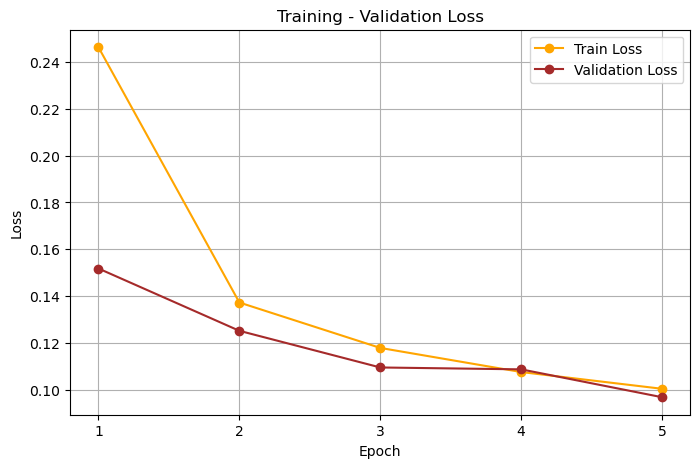

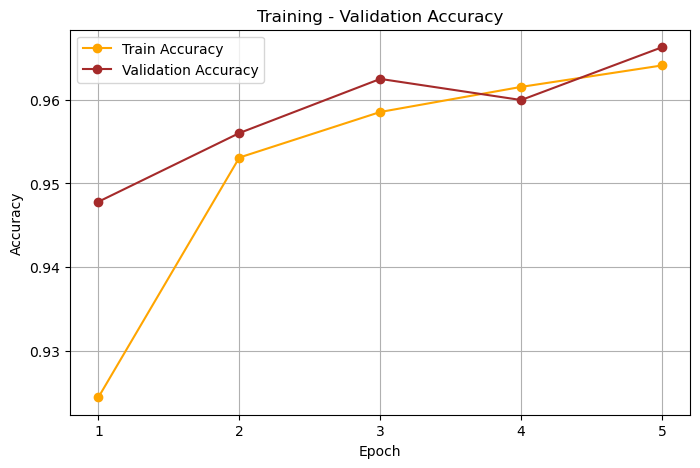

In [26]:
distilbert_results = train_and_evaluate("distilbert-base-uncased", num_epochs = 5, lr = 1e-3)
print("DistilBERT Results:", distilbert_results)
plot_epoch_metrics(
    distilbert_results["epoch_train_loss"],
    distilbert_results["epoch_train_accuracy"],
    distilbert_results["epoch_validation_loss"],
    distilbert_results["epoch_validation_accuracy"]
)

ELECTRA -> Training, Test, and Performance

MPS is used for training


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[google/electra-base-discriminator] Epoch 1 of 5 
Train Loss: 0.328, Train Accuracy: 0.880
Validation Loss: 0.222, Validation Accuracy: 0.923

[google/electra-base-discriminator] Epoch 2 of 5 
Train Loss: 0.218, Train Accuracy: 0.922
Validation Loss: 0.185, Validation Accuracy: 0.931

[google/electra-base-discriminator] Epoch 3 of 5 
Train Loss: 0.196, Train Accuracy: 0.930
Validation Loss: 0.156, Validation Accuracy: 0.949

[google/electra-base-discriminator] Epoch 4 of 5 
Train Loss: 0.183, Train Accuracy: 0.935
Validation Loss: 0.143, Validation Accuracy: 0.954

[google/electra-base-discriminator] Epoch 5 of 5 
Train Loss: 0.175, Train Accuracy: 0.935
Validation Loss: 0.147, Validation Accuracy: 0.945

Test Accuracy of google/electra-base-discriminator: 0.952
Test F1 of google/electra-base-discriminator : 0.951
Test Precision of google/electra-base-discriminator : 0.972
Test Recall of google/electra-base-discriminator: 0.931
----------------------------------------------------------

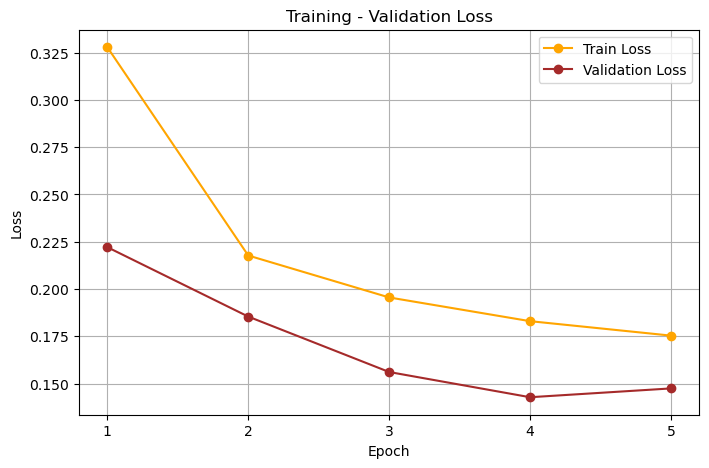

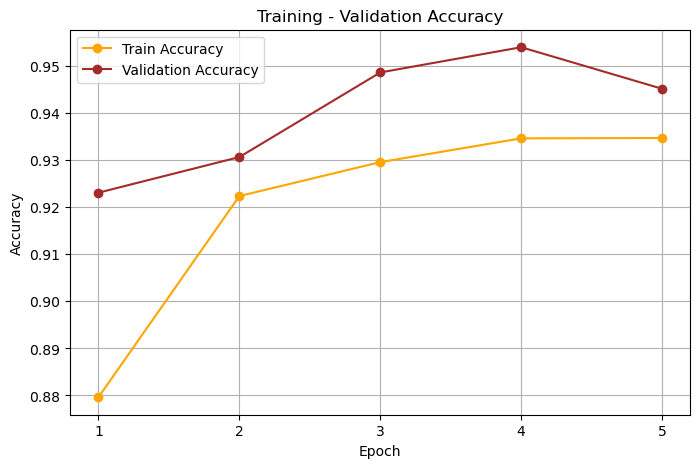

In [ ]:
electra_results = train_and_evaluate("google/electra-base-discriminator", num_epochs = 5, lr = 1e-3)

print("ELECTRA Results:", electra_results)

plot_epoch_metrics(
    electra_results["epoch_train_loss"],
    electra_results["epoch_train_accuracy"],
    electra_results["epoch_validation_loss"],
    electra_results["epoch_validation_accuracy"]
)


3. Saving the best model

In [28]:
torch.save(distilbert_results["model"].state_dict(), "best_model_for_classifier.pth")

   **Performance Comparison and Trend Discussion**

   Loss: DistilBERT shows faster and more stable convergence compared to ELECTRA. The training and validation loss of DistilBERT decrease rapidly and remain close. This can express good generalization. On the other hand, ELECTRA’s loss decreases more slowly. I can see the slight increase in validation loss at later epochs. DistilBERT performs more consistently for this classification task.

   Accuracy: DistilBERT shows stable and consistent performance with both training and validation accuracy during all epochs. In contrast, ELECTRA achieves higher validation accuracy than training accuracy. But the performance gap is not small in early epochs. ELECTRA may be slightly underfitting the training data compared to DistilBERT.

   Test Performance: DistilBERT is better than ELECTRA in this classification task. DistilBERT achieved higher accuracy and F1 score. While ELECTRA showed slightly better precision, the recall was lower than DistilBERT. This means that it missed more positive samples. Overall, DistilBERT was more balanced and consistent. So DistilBERT can be a better choice.


   **References**
   - Dataset URL: https://huggingface.co/datasets/SetFit/enron_spam
   - Huggingface Transfer Learning (https://huggingface.co/learn/nlp-course/chapter3/3?fw=pt)
   - Huggingface Fine-tuning (https://huggingface.co/learn/nlp-course/chapter3)
   - Huggingface BERT (https://huggingface.co/google-bert/bert-base-uncased)
   - Google AI Blog BERT (https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)
   - Visualized BERT(https://jalammar.github.io/illustrated-bert/)
